## t-Distributed Stochastic Neighbour Embedding (t-SNE)

t-SNE is a tool to visualize high-dimensional data. We'll use t-SNE to analyse the clustering tendency of CSI data among different activity classes and gain valuable insights
from the manifold embeddings.

---

In [54]:
import sys

sys.path.insert(0, "..")

import scipy.io
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from HAR.transformers import CSIMinMaxScaler
from HAR.io import load_dataset

sns.set_theme()


def get_coords_embedded(X):
    tsne = TSNE(
        n_components=2,
        perplexity=25,
        n_iter=5000,
        n_iter_without_progress=300,
        random_state=3,
        n_jobs=-1,
    )

    Xemb = tsne.fit_transform(X)

    return Xemb[:, 0], Xemb[:, 1]

### [1] Analysing clusterability on a day by day basis

We are looking at data collected in the same environment but on two different days. Minute changes in the environment will lead to cascading multi-path effects which will affect CSI data.

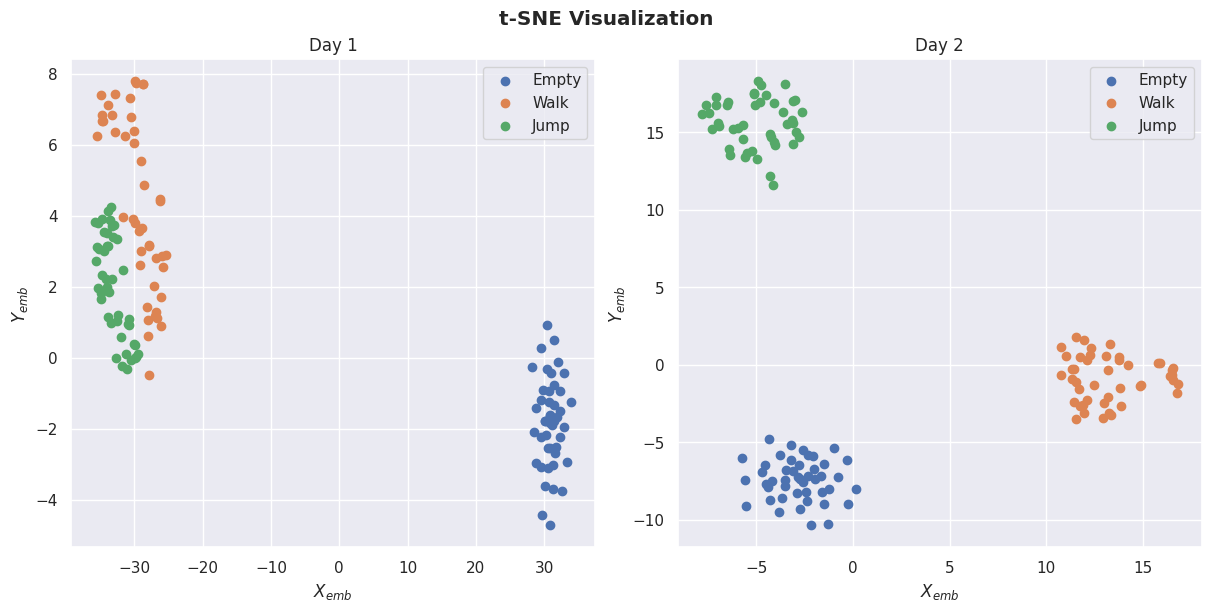

In [55]:
X1, y1, nsamples1, classnames1, dim1 = load_dataset("../dataset/rCSI-1")
X2, y2, nsamples2, classnames2, dim2 = load_dataset("../dataset/rCSI-2")

scaler = CSIMinMaxScaler()

X1 = X1.reshape(X1.shape[0], *dim1)
X1 = scaler.fit_transform(X1)
X1 = X1.reshape(X1.shape[0], dim1[0] * dim1[1])

X2 = X2.reshape(X2.shape[0], *dim1)
X2 = scaler.fit_transform(X2)
X2 = X2.reshape(X2.shape[0], dim2[0] * dim2[1])

xc1, yc1 = get_coords_embedded(X1)
xc2, yc2 = get_coords_embedded(X2)

plt.figure(figsize=(12, 6), constrained_layout=True)

plt.subplot(1, 2, 1)
for i in range(len(classnames1)):
    plt.scatter(
        xc1[np.sum(nsamples1[:i]) : np.sum(nsamples1[: i + 1])],
        yc1[np.sum(nsamples1[:i]) : np.sum(nsamples1[: i + 1])],
        label=classnames1[i],
    )
    plt.xlabel(r"$X_{emb}$")
    plt.ylabel(r"$Y_{emb}$")
    plt.legend()
    plt.title("Day 1")

plt.subplot(1, 2, 2)
for i in range(len(classnames1)):
    plt.scatter(
        xc2[np.sum(nsamples2[:i]) : np.sum(nsamples2[: i + 1])],
        yc2[np.sum(nsamples2[:i]) : np.sum(nsamples2[: i + 1])],
        label=classnames2[i],
    )
    plt.xlabel(r"$X_{emb}$")
    plt.ylabel(r"$Y_{emb}$")
    plt.legend()
    plt.title("Day 2")

plt.suptitle("t-SNE Visualization", fontweight="bold")
plt.show()

We see that the activities are clustering out really well each day. But what if we perform t-SNE on the entire data? Will we see a similar clustering tendency?

### [2] Analysing CSI data collectively

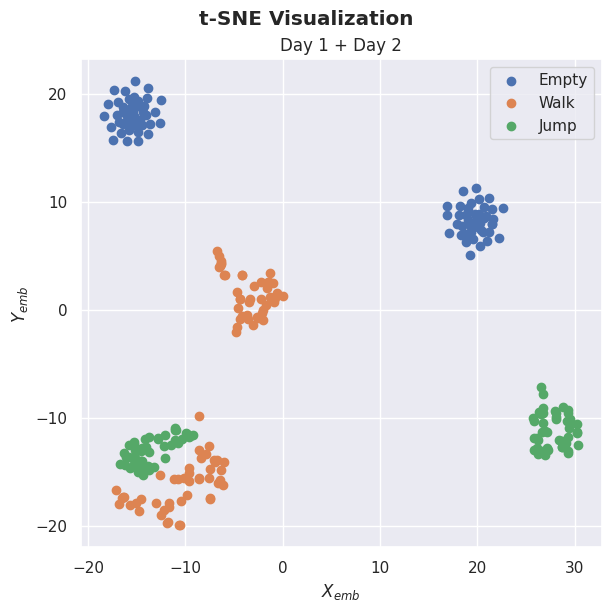

In [56]:
X3 = np.vstack(
    (X1[y1 == 0], X2[y2 == 0], X1[y1 == 1], X2[y2 == 1], X1[y1 == 2], X2[y2 == 2])
)
y3 = np.hstack(
    (y1[y1 == 0], y2[y2 == 0], y1[y1 == 1], y2[y2 == 1], y1[y1 == 2], y2[y2 == 2])
)
nsamples3 = nsamples1 + nsamples2
xc3, yc3 = get_coords_embedded(X3)
plt.figure(figsize=(6, 6), constrained_layout=True)
for i in range(len(classnames1)):
    plt.scatter(
        xc3[np.sum(nsamples3[:i]) : np.sum(nsamples3[: i + 1])],
        yc3[np.sum(nsamples3[:i]) : np.sum(nsamples3[: i + 1])],
        label=classnames1[i],
    )
    plt.xlabel(r"$X_{emb}$")
    plt.ylabel(r"$Y_{emb}$")
    plt.legend()
    plt.title("Day 1 + Day 2")

plt.suptitle("t-SNE Visualization", fontweight="bold")
plt.show()

Activities from each day is clustering independantly. We hypothesise this is due to a combined effect of minute changes in environment leading to cascading multi-path effects and human error. Any learning algorithm trained on the data in the current representation will most likely perform poorly on unseen data captured on a different day. 